In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import shapely.geometry as sg
import numpy as np
import pyproj
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import joblib as jl
import traffic
from traffic.core import Traffic


%matplotlib inline

In [2]:
unc_asp_tfc_gdf = gpd.GeoDataFrame(pd.read_pickle('../data/southeng/southeng_unc_asp_tfc_2019.pkl.bz2', compression='bz2'))
unc_asp_tfc_gdf = unc_asp_tfc_gdf.to_crs('epsg:3857')
unc_asp_tfc_gdf[unc_asp_tfc_gdf.select_dtypes(np.float16).columns] = unc_asp_tfc_gdf.select_dtypes(
        np.float16).astype(np.float64)

In [3]:
traj_gdf = gpd.read_file('../data/test_traj/QA-IOW.geojson').set_crs('epsg:4326').to_crs('epsg:3857')
traj_alt = 1000 #m
lat_buffer = 500 #m
vert_buffer = 500 #m
traj_gdf

,geometry
0,"LINESTRING (-119012.453 6594719.271, -112477.0..."


In [4]:
unc_asp_tfc_gdf

,timestamp,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,latitude,longitude,...,spi,squawk,track,vertical_rate,flight_id,track_unwrapped,geometry,name,type,icaoClass
552,2019-01-01 13:26:30+00:00,False,500.0,FGITZ,1300.0,89.0,2019-01-01 13:00:00+00:00,392279,51.90625,-2.082031,...,False,7000,259.75000,-704.0,FGITZ_096,259.75,POINT (-231770.659 6783191.970),UNCONTROLLED AIRSPACE,0,6
553,2019-01-01 13:27:00+00:00,False,500.0,FGITZ,1250.0,75.0,2019-01-01 13:00:00+00:00,392279,51.90625,-2.095703,...,False,7000,266.25000,-320.0,FGITZ_096,266.25,POINT (-233292.605 6783191.970),UNCONTROLLED AIRSPACE,0,6
554,2019-01-01 13:27:30+00:00,False,200.0,FGITZ,950.0,78.0,2019-01-01 13:00:00+00:00,392279,51.90625,-2.113281,...,False,7000,263.25000,-512.0,FGITZ_096,263.25,POINT (-235249.393 6783191.970),UNCONTROLLED AIRSPACE,0,6
794,2019-01-01 13:30:00+00:00,False,700.0,DIDWC,1375.0,138.0,2019-01-01 13:00:00+00:00,3e2172,51.37500,0.060791,...,False,4102,205.25000,-768.0,DIDWC_168,205.25,POINT (6767.225 6687896.878),UNCONTROLLED AIRSPACE,0,6
795,2019-01-01 13:30:30+00:00,False,275.0,DIDWC,1050.0,112.0,2019-01-01 13:00:00+00:00,3e2172,51.34375,0.048187,...,False,4102,207.75000,-704.0,DIDWC_168,207.75,POINT (5364.181 6682325.854),UNCONTROLLED AIRSPACE,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6645874,2019-12-31 13:44:00+00:00,False,200.0,N936CT,875.0,131.0,2019-12-31 13:00:00+00:00,acfc37,51.68750,0.169678,...,False,7000,53.21875,192.0,N936CT_2733,413.25,POINT (18888.439 6743817.483),UNCONTROLLED AIRSPACE,0,6
6645875,2019-12-31 13:44:30+00:00,False,225.0,N936CT,900.0,137.0,2019-12-31 13:00:00+00:00,acfc37,51.68750,0.179443,...,False,7000,228.00000,256.0,N936CT_2733,588.00,POINT (19975.543 6743817.483),UNCONTROLLED AIRSPACE,0,6
6645876,2019-12-31 13:45:00+00:00,False,250.0,N936CT,875.0,127.0,2019-12-31 13:00:00+00:00,acfc37,51.68750,0.153564,...,False,7000,310.75000,256.0,N936CT_2733,671.00,POINT (17094.717 6743817.483),UNCONTROLLED AIRSPACE,0,6
6645877,2019-12-31 13:45:30+00:00,False,175.0,N936CT,825.0,122.0,2019-12-31 13:00:00+00:00,acfc37,51.68750,0.132812,...,False,7000,188.00000,-192.0,N936CT_2733,548.00,POINT (14784.620 6743817.483),UNCONTROLLED AIRSPACE,0,6


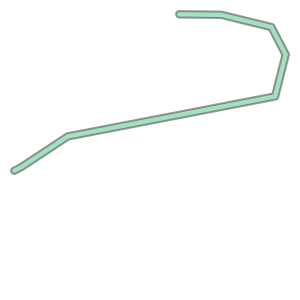

In [5]:
traj_poly = traj_gdf.buffer(lat_buffer).iloc[0]
traj_poly_gdf = gpd.GeoDataFrame(geometry=[traj_poly])
traj_poly

In [6]:
x_res = 1000
y_res = 1000
unc_asp_tfc = Traffic(unc_asp_tfc_gdf)
tfc_unc_xy_gdf = unc_asp_tfc.compute_xy('epsg:3857')
tfc_agg = tfc_unc_xy_gdf.assign(
    x=lambda elt: (elt.x // x_res) * x_res,
    y=lambda elt: (elt.y // y_res) * y_res,
).groupby(["x", "y"]).agg(altitude_mean=pd.NamedAgg('altitude', np.nanmean),
                          altitude_std=pd.NamedAgg('altitude', np.std), track_mean=pd.NamedAgg('track', np.nanmean),
                          track_std=pd.NamedAgg('track', np.nanstd),
                          groundspeed_mean=pd.NamedAgg('groundspeed', np.nanmean),
                          groundspeed_std=pd.NamedAgg('groundspeed', np.nanstd),
                          flight_id_nunique=('flight_id', 'nunique'))
tfc_agg['flight_id_nunique'] = tfc_agg['flight_id_nunique']/0.21

In [7]:
def make_centrepoint_box(x, y, x_res, y_res):
    half_x_res = x_res/2
    half_y_res = y_res/2
    return sg.box(x-half_x_res, y-half_y_res, x+half_x_res, y+half_y_res)

tfc_agg_gdf = tfc_agg.reset_index()
# tfc_agg_gdf = gpd.GeoDataFrame(tfc_agg_gdf, geometry=gpd.points_from_xy(tfc_agg_gdf.x, tfc_agg_gdf.y, crs='epsg:3857'))
tfc_agg_gdf = gpd.GeoDataFrame(tfc_agg_gdf, geometry=[make_centrepoint_box(x, y, x_res, y_res) for x,y in zip(tfc_agg_gdf.x, tfc_agg_gdf.y)] , crs='epsg:3857')
# sg.box

In [8]:
tfc_agg_gdf[tfc_agg_gdf.within(traj_poly.envelope)]

,x,y,altitude_mean,altitude_std,track_mean,track_std,groundspeed_mean,groundspeed_std,flight_id_nunique,geometry
6801,-144000.0,6571000.0,627.112595,347.127561,202.926318,72.646871,56.630964,39.102756,338.095238,"POLYGON ((-143500.000 6570500.000, -143500.000..."
6802,-144000.0,6577000.0,864.742268,274.229300,171.306862,123.987852,92.618557,28.290326,219.047619,"POLYGON ((-143500.000 6576500.000, -143500.000..."
6803,-144000.0,6582000.0,647.233960,279.981283,139.018025,96.918453,90.861449,36.094164,542.857143,"POLYGON ((-143500.000 6581500.000, -143500.000..."
6804,-144000.0,6588000.0,718.589286,247.834673,155.956473,97.822070,99.619048,30.946088,252.380952,"POLYGON ((-143500.000 6587500.000, -143500.000..."
6836,-143000.0,6571000.0,701.615385,274.900195,188.892471,83.900527,90.552885,31.489049,223.809524,"POLYGON ((-142500.000 6570500.000, -142500.000..."
...,...,...,...,...,...,...,...,...,...,...
8532,-103000.0,6571000.0,872.250000,315.061237,133.257812,121.683574,151.500000,83.340666,19.047619,"POLYGON ((-102500.000 6570500.000, -102500.000..."
8533,-103000.0,6577000.0,732.142857,410.769682,232.187500,106.945901,110.000000,54.270925,28.571429,"POLYGON ((-102500.000 6576500.000, -102500.000..."
8534,-103000.0,6582000.0,943.113636,235.108533,163.361328,110.409406,108.090909,53.217352,100.000000,"POLYGON ((-102500.000 6581500.000, -102500.000..."
8535,-103000.0,6588000.0,1013.821429,140.277693,229.504464,95.087253,103.875000,18.545876,57.142857,"POLYGON ((-102500.000 6587500.000, -102500.000..."


In [9]:
lat_intersect_gdf = tfc_agg_gdf[tfc_agg_gdf.intersects(traj_poly)]
# d3_intersect_gdf = lat_intersect_gdf[(lat_intersect_gdf['altitude'] <= traj_alt+vert_buffer) & (lat_intersect_gdf['altitude'] >= traj_alt-vert_buffer)]

In [10]:
lat_raw_tf_intersect_gdf = unc_asp_tfc_gdf[unc_asp_tfc_gdf.intersects(traj_poly)]

In [11]:
lat_raw_tf_intersect_gdf['hour'] = pd.DatetimeIndex(lat_raw_tf_intersect_gdf['timestamp']).hour
lat_raw_tf_intersect_gdf['month'] = pd.DatetimeIndex(lat_raw_tf_intersect_gdf['timestamp']).month

/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [12]:
lat_raw_tf_intersect_gdf

,timestamp,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,latitude,longitude,...,squawk,track,vertical_rate,flight_id,track_unwrapped,geometry,name,type,icaoClass,month
7139,2019-01-01 06:25:30+00:00,False,900.0,CG175,1650.0,129.000,6,406de8,50.81250,-0.922852,...,23,266.500000,0.0,CG175_1234,266.500000,POINT (-102731.366 6588193.921),UNCONTROLLED AIRSPACE,0,6,1
19456,2019-01-02 12:11:30+00:00,False,837.5,GKAIR,2000.0,116.000,12,402217,50.75000,-1.152344,...,7000,281.000000,-640.0,GKAIR_928,281.000000,POINT (-128278.319 6577190.192),UNCONTROLLED AIRSPACE,0,6,1
19457,2019-01-02 12:12:00+00:00,False,425.0,GKAIR,2000.0,116.000,12,402217,50.75000,-1.179688,...,7000,281.000000,-640.0,GKAIR_928,281.000000,POINT (-131322.212 6577190.192),UNCONTROLLED AIRSPACE,0,6,1
22672,2019-01-02 11:38:30+00:00,0.0,175.0,CG175,1175.0,123.000,11,406de6,50.71875,-1.284180,...,7000,14.601562,0.0,CG175_1383,14.601562,POINT (-142954.229 6571693.836),UNCONTROLLED AIRSPACE,0,6,1
22673,2019-01-02 11:39:00+00:00,0.0,150.0,CG175,1150.0,116.000,11,406de6,50.71875,-1.277344,...,7000,13.070312,0.0,CG175_1383,13.070312,POINT (-142193.256 6571693.836),UNCONTROLLED AIRSPACE,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6613159,2019-12-29 11:32:00+00:00,False,425.0,GSHAZ,1125.0,66.000,11,40774f,50.84375,-0.962402,...,7011,238.000000,-64.0,GSHAZ_1861,238.000000,POINT (-107134.139 6593701.308),UNCONTROLLED AIRSPACE,0,6,12
6613160,2019-12-29 11:32:30+00:00,False,425.0,GSHAZ,1100.0,72.000,11,40774f,50.84375,-0.976562,...,7011,278.000000,320.0,GSHAZ_1861,278.000000,POINT (-108710.440 6593701.308),UNCONTROLLED AIRSPACE,0,6,12
6613161,2019-12-29 11:33:00+00:00,False,475.0,GSHAZ,1175.0,71.000,11,40774f,50.84375,-0.991211,...,7011,279.750000,-64.0,GSHAZ_1861,279.750000,POINT (-110341.097 6593701.308),UNCONTROLLED AIRSPACE,0,6,12
6620086,2019-12-30 07:52:00+00:00,0.0,775.0,BAW70Y,4176.0,251.625,7,400a7c,50.75000,-1.144531,...,2161,228.250000,626.5,BAW70Y_540,228.250000,POINT (-127408.636 6577190.192),UNCONTROLLED AIRSPACE,0,6,12


/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/cartes/osm/requests.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


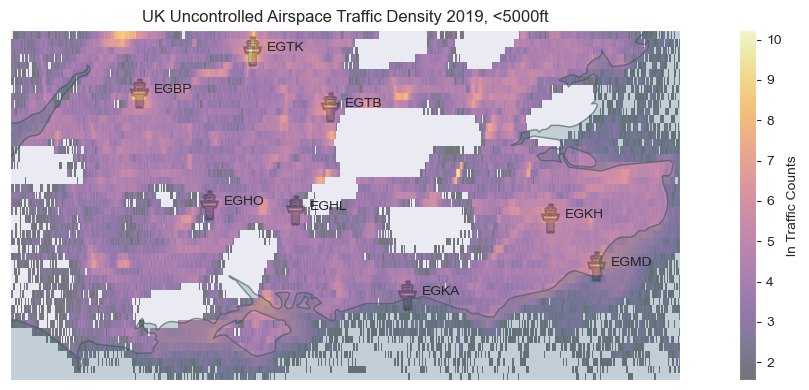

In [13]:
from cartes.crs import LambertConformal, EPSG_27700, PlateCarree, EuroPP, Mercator, Projection
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports
bounds = (-2.9, 1.5, 50.5, 51.9)

fig, ax = plt.subplots(
    1, 1, figsize=(12,4), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())
# ax.set_extent(bounds)
# ax.set_global()
tfc_magg = tfc_agg

xs = np.sort(tfc_magg['flight_id_nunique'].reset_index()['x'].unique().astype(int))
ys = np.sort(tfc_magg['flight_id_nunique'].reset_index()['y'].unique().astype(int))

pcm = ax.pcolormesh(xs, ys, np.log(tfc_magg['flight_id_nunique'].reset_index().pivot_table('flight_id_nunique', 'y', 'x', fill_value=np.nan))
, cmap='inferno', alpha=0.5)

# ax.add_geometries([traj_poly], 'epsg:3857', facecolor='red', edgecolor='red', alpha=0.3)

airports['EGHL'].point.plot(ax, alpha=0.2)
airports['EGTK'].point.plot(ax, alpha=0.2)
airports['EGKA'].point.plot(ax, alpha=0.2)
airports['EGMD'].point.plot(ax, alpha=0.2)
airports['EGTB'].point.plot(ax, alpha=0.2)
airports['EGHO'].point.plot(ax, alpha=0.2)
airports['EGBP'].point.plot(ax, alpha=0.2)
airports['EGKH'].point.plot(ax, alpha=0.2)

cb = fig.colorbar(pcm)
cb.set_label('ln Traffic Counts')
ax.set_title('UK Uncontrolled Airspace Traffic Density 2019, <5000ft')

fig.tight_layout()
fig.savefig('full_unc_counts.svg')

In [14]:
traj_poly.bounds

(-145176.17270300398,
 6569893.199178016,
 -101964.24515822314,
 6595219.236650961)

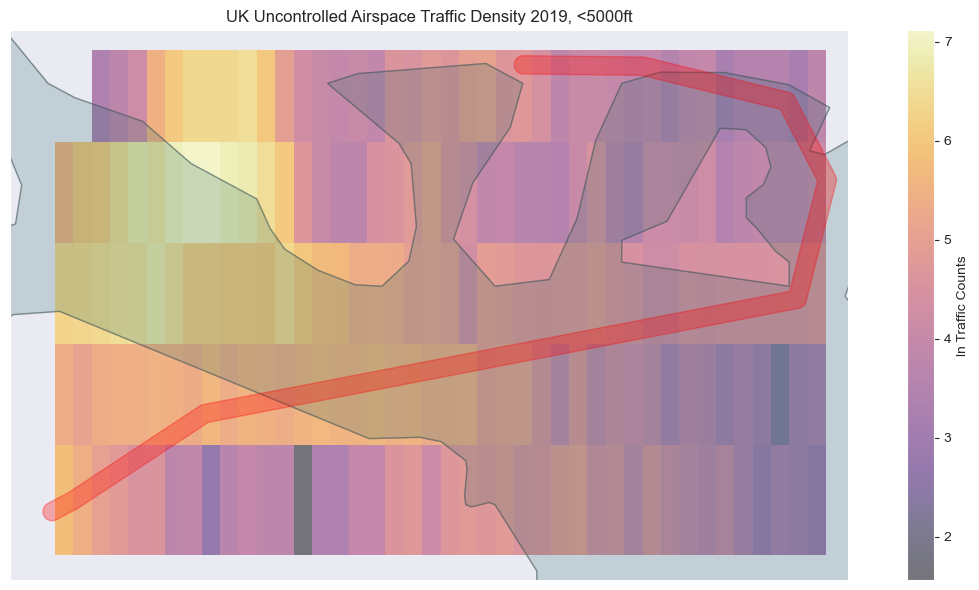

In [15]:
from cartes.crs import LambertConformal, EPSG_27700, PlateCarree, EuroPP, Mercator, Projection
from traffic.drawing import countries, lakes, ocean
import shapely.geometry as sg
bounds = (-2.9, 1.5, 50.5, 51.9)

fig, ax = plt.subplots(
    1, 1, figsize=(12,6), subplot_kw=dict(projection=Projection('epsg:3857')),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())
ax.set_extent((-1.32, -0.91, 50.69, 50.86))#[traj_poly.bounds[0],traj_poly.bounds[2], traj_poly.bounds[1],traj_poly.bounds[3]])
# ax.set_global()

xs = np.sort(tfc_agg_gdf[tfc_agg_gdf.within(traj_poly.envelope)]['x'].unique().astype(int))
ys = np.sort(tfc_agg_gdf[tfc_agg_gdf.within(traj_poly.envelope)]['y'].unique().astype(int))

ax.add_geometries([traj_poly], 'epsg:3857', facecolor='red', edgecolor='red', alpha=0.3)

pcm = ax.pcolormesh(xs, ys, np.log(tfc_agg_gdf[tfc_agg_gdf.within(traj_poly.envelope)].pivot_table('flight_id_nunique', 'y', 'x', fill_value=np.nan))
, cmap='inferno', alpha=0.5)


cb = fig.colorbar(pcm)
cb.set_label('ln Traffic Counts')
ax.set_title('UK Uncontrolled Airspace Traffic Density 2019, <5000ft')

fig.tight_layout()
fig.savefig('geom_unc_counts.png')

In [16]:
cell_vol = x_res * y_res * 304.8 * 5 # Up to 5000ft
FT2M = 0.3048
HRS_IN_YR = 8766
buffer_mean_tfc_dens = lat_intersect_gdf['flight_id_nunique'].sum()/(traj_poly.area*2*vert_buffer)/HRS_IN_YR
buffer_max_tfc_dens = lat_intersect_gdf['flight_id_nunique'].max()/cell_vol/HRS_IN_YR
print(f'Along trajectory buffer:')
print(f'Mean traffic density is {buffer_mean_tfc_dens:.6} aircraft/m^3/hour equiv to 1 aircraft per {np.sqrt(1/(buffer_mean_tfc_dens*500*FT2M))/9:.6}m x 500ft in an hour')
print(f'Max traffic density is {buffer_max_tfc_dens:.6} aircraft/m^3/hour equiv to 1 aircraft per {np.sqrt(1/(buffer_max_tfc_dens*500*FT2M))/9:.6}m x 500ft in an hour')


Along trajectory buffer:
Mean traffic density is 7.79239e-12 aircraft/m^3/hour equiv to 1 aircraft per 3224.26m x 500ft in an hour
Max traffic density is 2.53077e-11 aircraft/m^3/hour equiv to 1 aircraft per 1789.12m x 500ft in an hour


In [17]:
n_lis_sq = len(lat_raw_tf_intersect_gdf[lat_raw_tf_intersect_gdf['squawk'].isin(['4306', '7011'])])
print(f'{n_lis_sq} aircraft are on local listening squawks. This is {n_lis_sq/len(lat_raw_tf_intersect_gdf):.1%} of aircraft along trajectory')

80 aircraft are on local listening squawks. This is 9.6% of aircraft along trajectory


### Traffic Motion Distributions:

[Text(0.5, 1.0, 'Traffic altitude along trajectory buffer'),
 Text(0.5, 0, 'Altitude [ft] 500ft Bins'),
 Text(0, 0.5, 'Freq Density')]

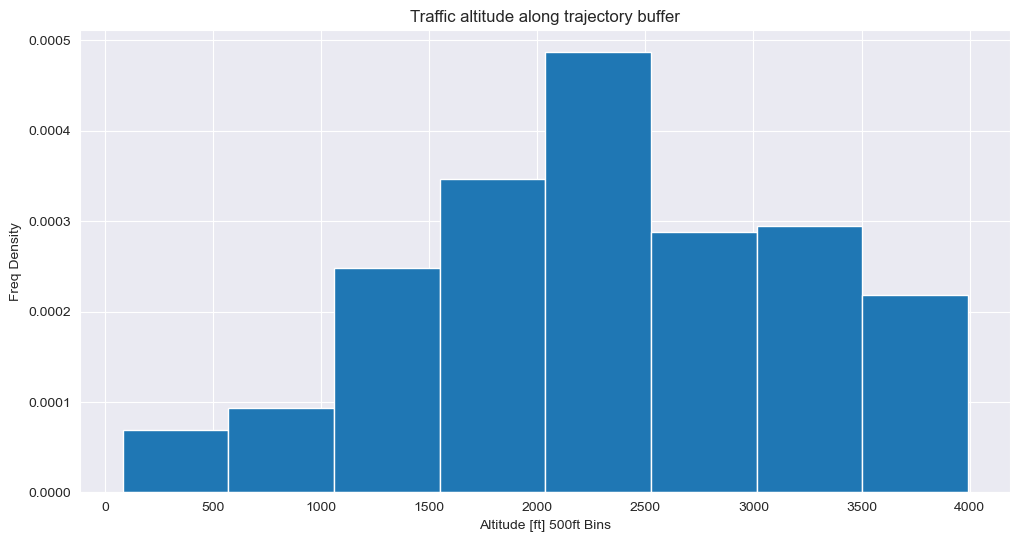

In [18]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

(lat_raw_tf_intersect_gdf['altitude']/FT2M).hist(ax=ax, density=True, bins=8)
ax.set(title='Traffic altitude along trajectory buffer', xlabel='Altitude [ft] 500ft Bins', ylabel='Freq Density')

[Text(0.5, 1.0, 'Traffic track along trajectory buffer'),
 Text(0.5, 0, 'Track [deg] 20deg Bins'),
 Text(0, 0.5, 'Freq Density')]

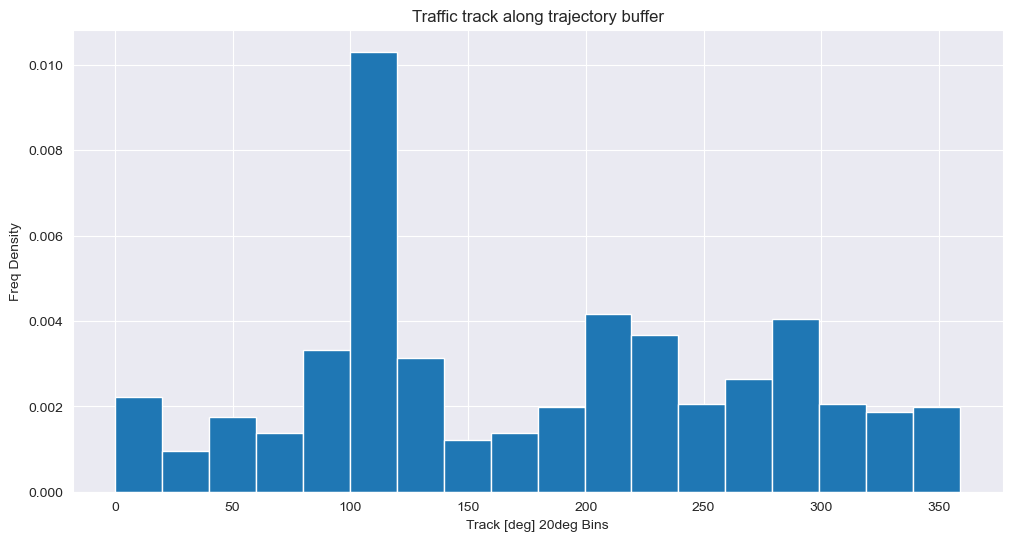

In [19]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

(lat_raw_tf_intersect_gdf['track']).hist(ax=ax, density=True, bins=18)
ax.set(title='Traffic track along trajectory buffer', xlabel='Track [deg] 20deg Bins', ylabel='Freq Density')

[Text(0.5, 1.0, 'Traffic speed along trajectory buffer'),
 Text(0.5, 0, 'Speed [m/s]'),
 Text(0, 0.5, 'Freq Density')]

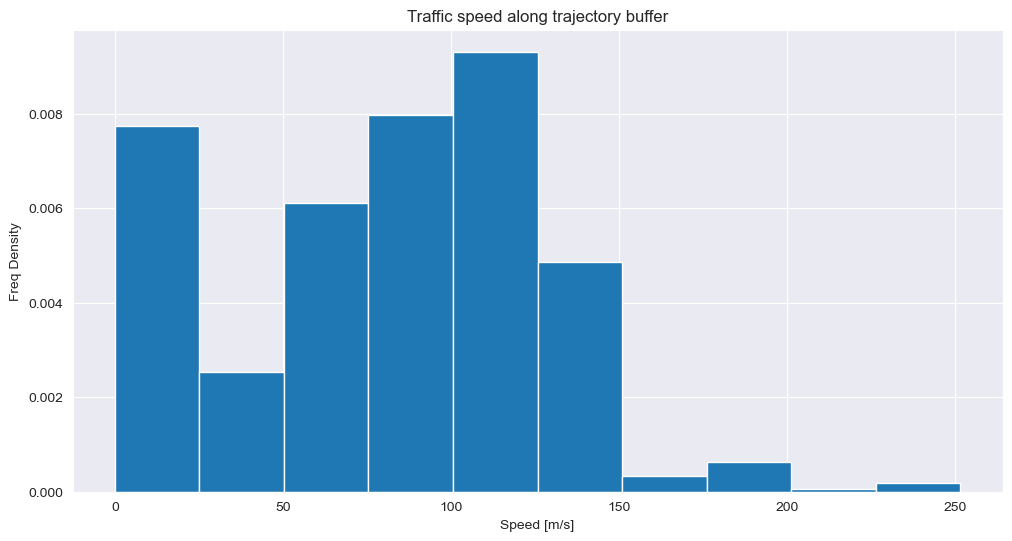

In [20]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

(lat_raw_tf_intersect_gdf['groundspeed']).hist(ax=ax, density=True)
ax.set(title='Traffic speed along trajectory buffer', xlabel='Speed [m/s]', ylabel='Freq Density')

[Text(0.5, 1.0, 'Traffic encounter Hour of Day'),
 Text(0.5, 0, 'Hour of Day'),
 Text(0, 0.5, 'Freq Density')]

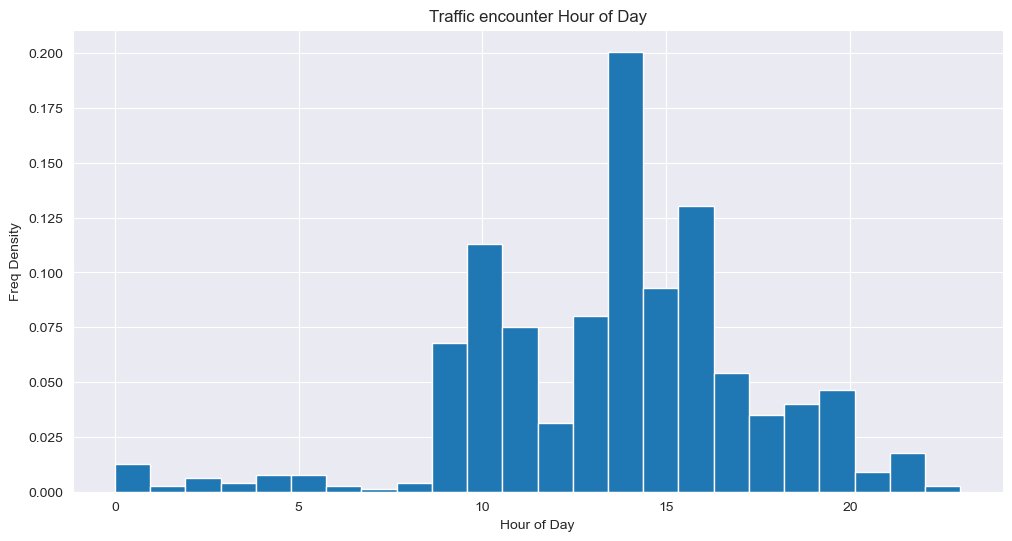

In [21]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

(lat_raw_tf_intersect_gdf['hour']).hist(ax=ax, density=True, bins=24)
ax.set(title='Traffic encounter Hour of Day', xlabel='Hour of Day', ylabel='Freq Density')

## Probability of Collision:
## The Ideal Gas method
For this section, we assume the traffic becomes an ideal gas, such that we can model it with the usual ideal gas law:

$$pV=nRt=n k_B N_A T = N k_B T$$

Obviously, we aren't dealing with an actual gas, therefore Boltzmann's relations between energy and temperature are not useful for us here. We can rewrite this using our own variables:

$$ p_{MAC} = \rho_t A_C |\vec{\overline{v_R}}| t$$

where:
- $p_{MAC}$ is the probability of mid air collision for within a period $t$
- $\rho_t$ is the air traffic density
- $A_C$ is the projected collision area. This is assumed to be the maximum cross section of an aircraft.
- $\vec{\overline{v_R}}$ is the mean relative velocity vector between aircraft.
- $t$ is the time horizon

Next, we make some assumptions

In [71]:
v_ac = 80 # ~250kts
A_C = 20*15
t = 1 # density is already per hour

In [72]:
v_rel_max = lat_raw_tf_intersect_gdf['groundspeed'].max() + v_ac # assume worst case head on
v_rel_mean = lat_raw_tf_intersect_gdf['groundspeed'].astype(float).mean() + v_ac # assume worst case head on
p_mac_max = float(buffer_max_tfc_dens) * A_C * v_rel_max * t
p_mac_mean = float(buffer_mean_tfc_dens) * A_C * v_rel_mean * t
print(f'Unmitigated Max Collision Probability is {p_mac_max:.3e} per flight hour, equiv to a single collision every {1/(p_mac_max*HRS_IN_YR):.3} years.')
print(f'Unmitigated Mean Collision Probability is {p_mac_mean:.3e} per flight hour, equiv to a single collision every {1/(p_mac_mean*HRS_IN_YR):.4} years.')

Unmitigated Max Collision Probability is 2.518e-06 per flight hour, equiv to a single collision every 45.3 years.
Unmitigated Mean Collision Probability is 3.746e-07 per flight hour, equiv to a single collision every 304.5 years.


## Agent Based Simulation Method

Here we use a simulated environment that is formed of 2 main components:

- Background Traffic
- Ownship Agent

As we are not really looking at the collision rate of the existing aircraft already flying around, instead we are interested in the potential collisions between our own aircraft/UAS (ownship) and the existing traffic. Therefore the simulation is divided along this line.

The background traffic is generated based on the traffic motion distributions for the area of operation (ie the ones above) and the maximum traffic density (although this can be mean as well, however we are angling for a feasible worst case).

The ownship then follows the trajectory path being analysed and any conflicts are recorded. This simulation is performed a great number of times following a Monte Carlo methodology. The conflict occurences can then be aggregated to form overall statistics for the expected collision rate specific to that operation.

In [62]:
# Setup the database for logging of runs
import sqlite3
dbcon = sqlite3.connect('../data/abs-specific.1e-9.db')
dbcur = dbcon.cursor()
dbcur.execute("CREATE TABLE IF NOT EXISTS sims(id, seed, timesteps, n_conflicts)")

In [25]:
from abs_specific import Simulation, Traffic, OwnshipAgent
import scipy.stats as ss
import os

# import dask
# from dask.distributed import Client, LocalCluster
#
# cluster = LocalCluster()
# client = Client()

# import ray
# ray.init(log_to_driver=False, ignore_reinit_error=True)

In [26]:
ownship_velocity = 70 #m/s
target_sim_hrs = 2.7e4
sim_per_batch = 500

# Sim compute setup
n_cores = int(os.cpu_count())
target_sim_secs = target_sim_hrs * 60 * 60
path_length = traj_gdf.iloc[0][0].length
exp_secs_per_sim = path_length / ownship_velocity
exp_n_sims = np.ceil(target_sim_secs / exp_secs_per_sim)
exp_n_jobs = int(np.ceil(exp_n_sims/sim_per_batch))
print(f'{exp_n_jobs} jobs at {sim_per_batch} simulations per job')

198 jobs at 500 simulations per job


In [27]:
path_length

68818.61266545641

In [ ]:
tb = traj_poly.envelope.bounds
sim_bounds = [tb[0], tb[2], tb[1], tb[3], 0, 1524]
sim_tfc_density = 1e-9 #tfc_agg_gdf[tfc_agg_gdf.within(traj_poly.envelope)]['flight_id_nunique'].max()/cell_vol/HRS_IN_YR
env_tfc = unc_asp_tfc_gdf[unc_asp_tfc_gdf.intersects(traj_poly.envelope)]
env_vel_kde = ss.gaussian_kde(env_tfc['groundspeed'])
env_track_kde = ss.gaussian_kde(env_tfc['track'])

own_path = np.hstack((np.array(traj_gdf.iloc[0][0].coords), traj_alt * np.ones((len(traj_gdf.iloc[0][0].coords)))[:, None]))

own_args = (own_path, ownship_velocity)
tfc_args = (sim_bounds, sim_tfc_density, env_vel_kde, ss.norm(0, 2), env_track_kde)
steps = 5000

In [ ]:
def run_sim(own_args, tfc_args, steps):
    seed = int.from_bytes(os.urandom(8), byteorder="big") % ((2**32) - 1)
    bg_tfc = Traffic(*tfc_args, seed=seed)
    own = OwnshipAgent(*own_args)

    spec_sim = Simulation(bg_tfc, own, steps=steps, seed=seed, conflict_dists=(20,20))
    spec_sim.run()
    # print(hash(spec_sim.traffic.positions.data.tobytes()))
    return spec_sim


def run_batch_sim(batch_size, own_args, tfc_args, steps):
    sims = [run_sim(own_args, tfc_args, steps) for _ in range(batch_size)]
    sim_ids = [s.sim_id for s in sims]
    sim_seeds = [s.sim_seed for s in sims]
    sims_conflict_sums = [s.conflict_log for s in sims]
    sims_times = [s.end_timestep for s in sims]
    db_data = zip(sim_ids, sim_seeds, sims_times, sims_conflict_sums)

    dbcon = sqlite3.connect('../data/abs-specific.db')
    dbcur = dbcon.cursor()
    dbcur.executemany("INSERT INTO sims VALUES (?,?,?,?)", db_data)
    dbcon.commit()

    # return sims

# sims = [run_sim(own_args, tfc_args, steps) for _ in range(20)]

jl.Parallel(n_jobs=n_cores, verbose=15, )(jl.delayed(run_batch_sim)(sim_per_batch, own_args, tfc_args, steps) for _ in range(exp_n_jobs))

# sims = [dask.delayed(run_batch_sim)(sim_per_batch, own_args, tfc_args, steps) for _ in range(exp_n_jobs)]
# dask.compute(*sims)

# sims = [run_batch_sim.remote(sim_per_batch, own_args, tfc_args, steps) for _ in range(exp_n_jobs)]
# ray.get(sims)

In [63]:
res = dbcur.execute("SELECT * FROM sims").fetchall()

In [64]:
sim_data = np.array(res, dtype=np.longlong)[:, 2:]
sim_data = np.cumsum(sim_data, axis=0)
n_sims = sim_data.shape[0]
n_conflicts = sim_data[-1,1]
sim_data = np.hstack((sim_data, (sim_data[:, 1] / (sim_data[:, 0]/3600))[:, None]))

In [65]:
print(f'Probability: {n_conflicts/n_sims:2e}')

Probability: 3.607769e-03


In [66]:
sim_data.dtype

dtype('float64')

In [67]:
print(sim_data.shape[0], ' sims run')
print(f'{sim_data.shape[0] * exp_secs_per_sim/3600:.2e} hours run' )

11906528  sims run
3.25e+06 hours run


Median uMAC rate 1.318599e-02 per hour


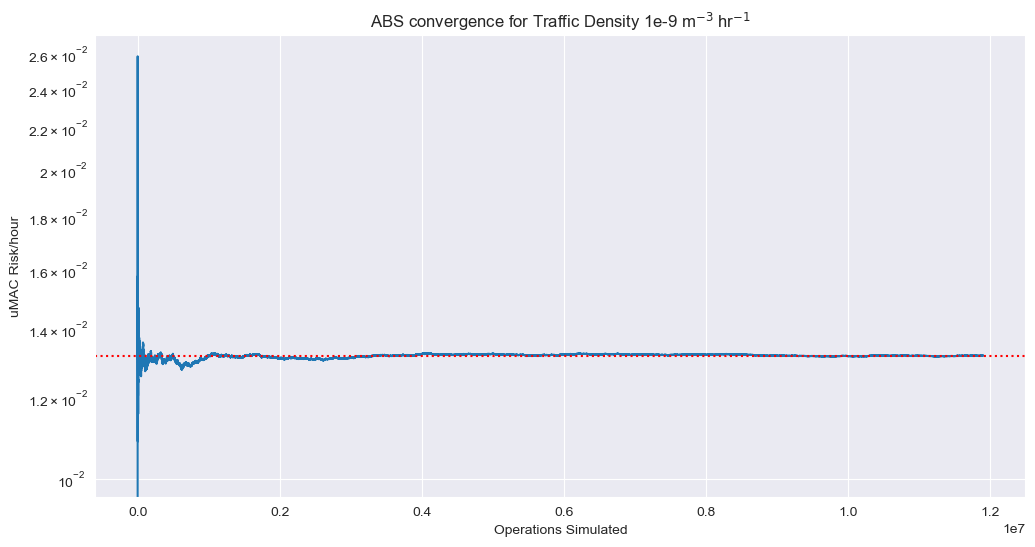

In [68]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.plot(range(sim_data.shape[0]), sim_data[:, 2])
ax.axhline(np.median(sim_data[:,2]), color='red', linestyle=':')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("ABS convergence for Traffic Density 1e-9 m$^{-3}$ hr$^{-1}$")
ax.set_xlabel("Operations Simulated")
ax.set_ylabel("uMAC Risk/hour")
print(f'Median uMAC rate {np.median(sim_data[:,2]):2e} per hour')

In [60]:
conflict_sum = sim_data[:, 2].sum()
sim_hrs = sim_data[:, 1].sum() / (60*60)
sim_ops = sim_data.shape[0]
mean_col_rate = conflict_sum / sim_hrs


print(f'{sim_hrs} flight hrs of operations simulated equiv. to {exp_n_sims} individual operations')
print(f'Max unmitigated collision rate {conflict_sum / sim_hrs:.2e} collisions per hour')
print(f'Max unmitigated collision rate {conflict_sum / sim_ops:.2e} collisions per operation or one unmitigated collision per {sim_ops / conflict_sum} operations')

2370660.6530555557 flight hrs of operations simulated equiv. to 98869.0 individual operations
Max unmitigated collision rate 3.74e-03 collisions per hour
Max unmitigated collision rate 1.27e-03 collisions per operation or one unmitigated collision per 790.3573537732315 operations
